### Machine Learning

- Maria Zazpe Quintana

- Alba Rodríguez Berenguel

En este notebook vamos a realizar un primer modelo base con DummyClassifier. Los pasos que vamos a seguir son:

1. Importación de librerías, funciones y datos.
2. Creación del modelo.
3. Entrenamiento del modelo.
4. Predicciones y evaluación.
5. Exportación del modelo.

## 1. Importación de librerías, funciones y datos.

In [1]:
# Load libraries
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import ConfusionMatrixDisplay, fbeta_score, plot_confusion_matrix
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, accuracy_score, classification_report
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
import scikitplot as skplt
from sklearn.inspection import PartialDependenceDisplay
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Function to evaluate the model
def evaluate_model(ytest, ypred, ypred_proba = None):
    if ypred_proba is not None:
        print('ROC-AUC score of the model: {}'.format(roc_auc_score(ytest, ypred_proba[:, 1])))
    print('Accuracy of the model: {}\n'.format(accuracy_score(ytest, ypred)))
    print('Classification report: \n{}\n'.format(classification_report(ytest, ypred)))

In [3]:
# Load data
X_train_val = pd.read_csv("../data/processed/X_train_val.csv",index_col=0 )
y_train_val = pd.read_csv("../data/processed/y_train_val.csv",index_col=0 )

x_val = pd.read_csv("../data/processed/X_val.csv",index_col=0 )
y_val = pd.read_csv("../data/processed/y_val.csv",index_col=0 )

## 2. Creación del modelo.

Vamos a utilizar el modelo DummyClassifier como modelo base, estableciendo que la estrategia sea “most_frequent”, es decir, su predicción será exclusivamente la clase que más se repite.

In [4]:
# Import the preprocessor.
preprocessor = pickle.load(open('../models/preprocessor.pickle', 'rb'))

# Create the classifier
classifier = DummyClassifier(strategy = 'most_frequent', random_state = 12345)

In [5]:
# We create a pipeline with the preprocessor and the classifier.
dummy_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier',  classifier)
])

## 3. Entrenamiento del modelo.

In [6]:
dummy_model.fit(X_train_val, y_train_val)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(fill_value='Unknown',
                                                                                 strategy='constant')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['delivery',
                                                   'outdoor_seating',
                                                   'credit_cards',
                                                   'bike_parking',
                                                   'price_range', 'take_out',
                                                   'wifi', 'alcohol', 'caters',
                                                   'wheelchair_accessible',
                                                   'good_for_kids', 'attire',
                                                   'reservations',
                                                   'table_service',
                                                   'good_for_groups', 'tv',
                                                   'noise_level']),
                                                 ('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['useful', 'funny',
                                                   'cool'])])),
                ('classifier',
                 DummyClassifier(random_state=12345,
                                 strategy='most_frequent'))])

## 4. Predicciones y evaluación.

In [7]:
# Predictions of target value for the validation set.
pred = dummy_model.predict(x_val)

# Predictions of probabilities of the target value for the validation set.
pred_proba = dummy_model.predict_proba(x_val)

### Precision, Recall, F1 y accuracy. 

In [8]:
# We evaluate the model with differents metrics with the function that we import.
evaluate_model(y_val, pred)

Accuracy of the model: 0.7206329356849684

Classification report: 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     45127
           1       0.72      1.00      0.84    116406

    accuracy                           0.72    161533
   macro avg       0.36      0.50      0.42    161533
weighted avg       0.52      0.72      0.60    161533




- **Support** nos dice los datos reales que tenemos, 43264 que son 0 y 110766 que son 1.


- La **precisión** se calcula con las columnas de la matriz de confusión y su precisión es nula (0) para los casos 0 y 0.72 para los casos 1. Acierta todas las puntuaciones altas (1) pero falla todas las bajas (0) al predecirlas como altas. La precisión es alta, pero debido a que la variable de destino está desequilibrada y la mayoría son 1.


- El **recall** se calcula con las filas de la matriz de confusión, la predicción es mala porque no logra identificar las puntuaciones bajas, pero acierta el 100% de las puntuaciones altas.


- El **f1** es la combinación de estas dos métricas, para tener una más exacta. Identifica 0.84 de puntuación alta, pero no identifica ninguna puntuación baja.


- El **accuracy** se calcula con la matriz de confusión, teniendo en cuanto los aciertos y es 0.72, es decir, que el modelo predice correctamente el 72% de los casos, pero esto no quiere decir que sea un buen modelo aunque su exactitud pueda parecer alta, como ya se ha visto con el resto de métricas, las predicciones no son buenas, este resultado se debe al desequilibrio del target.

### Matriz de confusión.

Confusion matrix, without normalization
[[     0  45127]
 [     0 116406]]
Normalized confusion matrix
[[0. 1.]
 [0. 1.]]


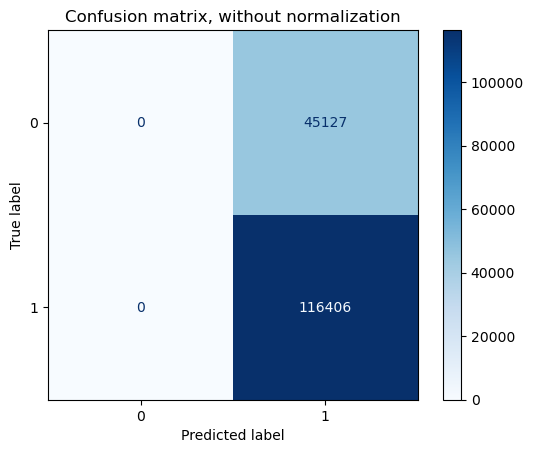

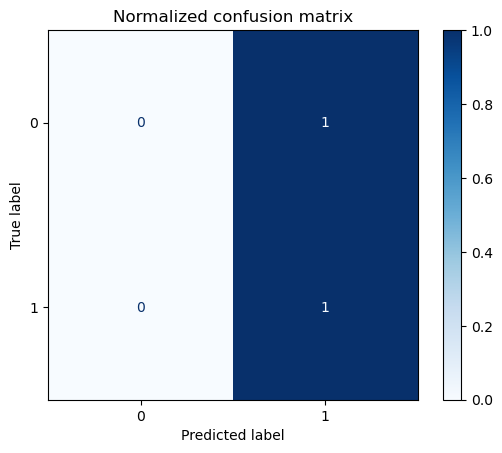

In [9]:
titles_options = [("Confusion matrix, without normalization", None),
                  ("Normalized confusion matrix", 'true')]

for title, normalize in titles_options: 
    disp = plot_confusion_matrix(dummy_model, x_val, y_val,
                                 cmap=plt.cm.Blues,
                                 normalize=normalize)
    disp.ax_.set_title(title)
    print(title)
    print(disp.confusion_matrix)
    
plt.show()

El modelo predice todo como puntuación alta (1) y este error se aprecia muy claramente en la matriz de confusión. Predice erroneamente 43264 valores que son 0 y el modelo los establece como 1. Los valores 1 que son 110766 sí los predice todos bien dado que era la finalidad del modelo, predecir todos como la categoría que más se repite.

### Curva ROC.

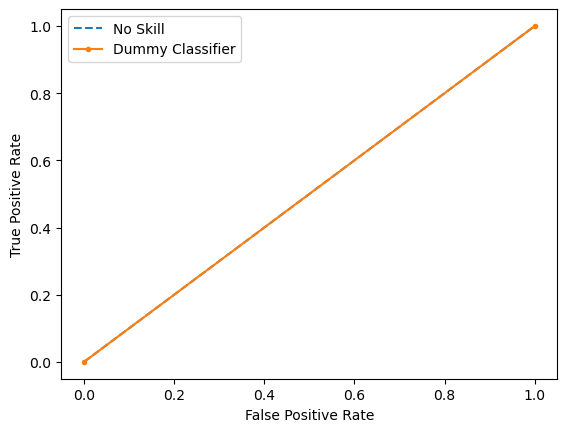

In [10]:
# Keep probabilities for the positive outcome only.
yhat = pred_proba[:, 1]

# Calculate roc curves.
fpr, tpr, thresholds = roc_curve(y_val, yhat)

# Plot the roc curve for the model.
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Dummy Classifier')

# Axis labels.
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()

# Show the plot.
plt.show()

Nuestro modelo no tiene capacidad de predicción, por lo que la curva ROC es una línea recta.

### Curva Lift. 

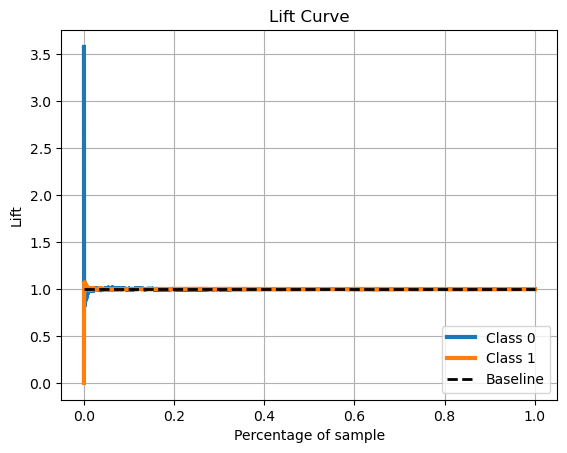

In [11]:
skplt.metrics.plot_lift_curve(y_val, pred_proba)
plt.show()

Para la clase 1 obtenemos una buena curva, pero la de la clase 0 está invertida porque la predicción es fatal, se ve como la curva también comienza desde muy abajo.

### Curva de ganancia. 

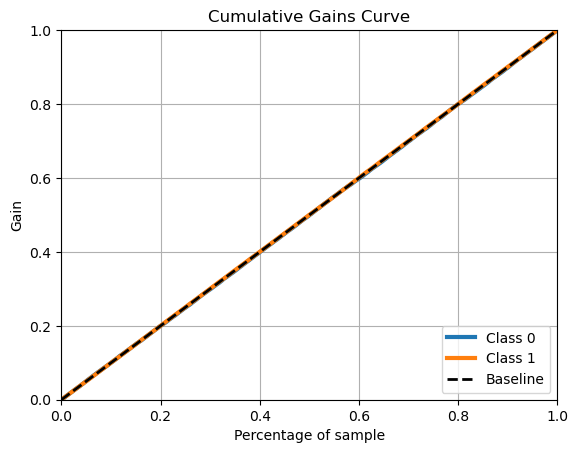

In [12]:
skplt.metrics.plot_cumulative_gain(y_val, pred_proba)
plt.show()

La curva de ganancia es una línea recta, por lo que el modelo no tiene capacidad de predicción. En ambas curvas se ve como la línea se encuentra sobre la línea de puntos, lo que indica que el modelo predeciría igual que si lo hacemos aleatoriamente.

In [13]:
# We save the model.
with open('../models/dummyclassifier.pickle', 'wb') as f:
    pickle.dump(dummy_model, f)

In [14]:
# To avoid the fit again.
with open('../models/dummyclassifier.pickle', 'rb') as f:
    dummy_model = pickle.load(f)